In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [34]:
spark = SparkSession.builder.appName('winterRain').getOrCreate()

In [35]:
from io import StringIO
import itertools
import numpy as np
import pandas as pd
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(40,10))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

<Figure size 2880x720 with 0 Axes>

In [36]:
%%time
def readFiles (feature):
    def process(tup):
        def convertTuple(tup): 
            str =  ''.join(tup) 
            return str

        # Driver code 
        str = convertTuple(tup[0:2]) 
        df = pd.read_csv(StringIO(str), header=None)

        # slicing the output and storing filename in "filename dataframe"
        filename = df[0:1]
        filename = filename.iloc[0][0].replace('txtncols         180','')
        filename = filename[-9:-1]

        # storing the content of file in "content dataframe"
        content = df[6:]

        counter = 0 
        allValues = 0

        # iterate through all the rows and columns of the file - better than for loop which took 40 mins
        modPandasDF=content.iloc[:,0].str.split(' ',expand=True).replace("-9999",float('NaN'))
        modPandasDF=modPandasDF.astype('float')
        modPandasDF=modPandasDF.values
        xDF=np.nanmean(modPandasDF)
        mean=np.nanmean(xDF)

        return filename, mean
    
    # daily grid data for rainfall
    if(feature=="rainfall" or feature=="maximum-temperature"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-daily/grid/"+feature+"/*"
    elif(feature=="sunshine" or feature=="snow-falling"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-monthly/"+feature+"/*"

    # Get rdd containing one record for each file.
    files_rdd = sc.wholeTextFiles(path, minPartitions=20)
    print(type(files_rdd))

    print('Number of records (months):', files_rdd.count())
    print('Number of partitions:', files_rdd.getNumPartitions())

    # map lines to n_words
    records = files_rdd.map(lambda n : process(n))

    # collect the RDD to a list
    llist = records.collect()

    # two arrays
    values = []
    months = []

    # store the filename in months array and its corrosponding value(mean) in values array
    for line in llist:
        values.append(line[1])
        months.append(line[0])

    # converting arrays to dataframes
    valuesdf = pd.DataFrame({'DailyMean':values[:]})
    yearmonthdf = pd.DataFrame({'YearMonth':months[:]})

    # merging two dataframes into one
    finaldf = pd.merge(yearmonthdf, valuesdf, left_index=True, right_index=True)

    # sort the index
    finaldf = finaldf.sort_values('YearMonth')

    # converting first column to integer format
    finaldf['YearMonth'] = finaldf['YearMonth'].astype('int')

    # converting first column from integer to datetime format
    finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format='%Y%m%d')

    # extracting year and month 
    finaldf['Year'] = finaldf['YearMonth'].dt.year
    finaldf['Month'] = finaldf['YearMonth'].dt.month

    print(finaldf.head())
    
    return finaldf

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 25.3 µs


<class 'pyspark.rdd.RDD'>
Number of records (months): 20820
Number of partitions: 20
       YearMonth  DailyMean  Year  Month
13541 1960-01-01   1.617598  1960      1
0     1960-01-02   1.112800  1960      1
9374  1960-01-03   3.992615  1960      1
1     1960-01-04   3.757235  1960      1
5208  1960-01-05   0.796998  1960      1


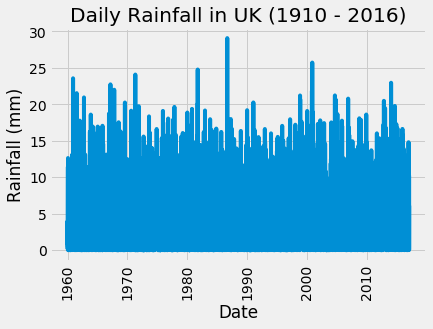

CPU times: user 475 ms, sys: 25.7 ms, total: 501 ms
Wall time: 4min 43s


In [37]:
%%time

finaldf = readFiles("rainfall")

plt.plot(finaldf.YearMonth, finaldf.DailyMean)
plt.title('Daily Rainfall in UK (1910 - 2016)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.show()

# Observation from plot: just plotting temp vs years makes no sense as it is not possible to observe any trends

In [62]:
z=pd.DataFrame(finaldf['YearMonth'])
z.insert(1,'DailyMean',finaldf['DailyMean'])
z.to_csv('WGWP1.csv', index=False)

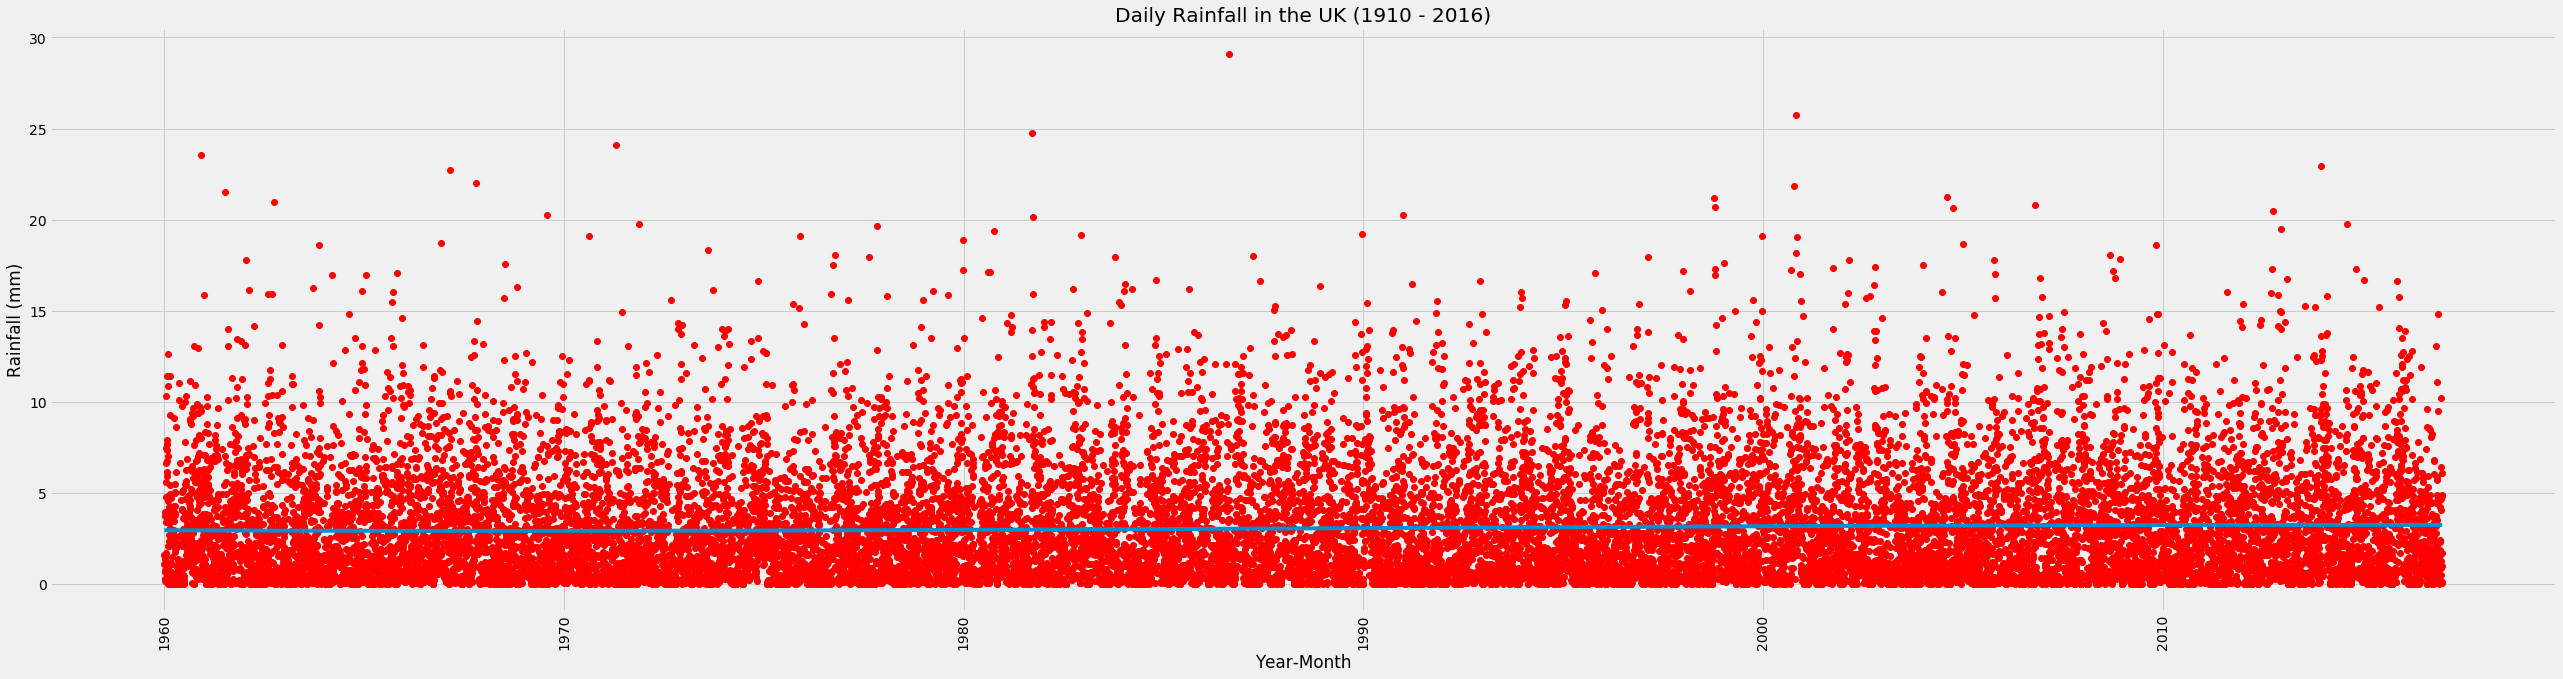

In [67]:
# BEST LINE FIT to look for any trend in data if present
y_values = finaldf['DailyMean']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(finaldf.loc[:, "DailyMean"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Daily Rainfall in the UK (1910 - 2016)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.plot(finaldf.loc[:, "YearMonth"], finaldf.loc[:,"DailyMean"], "ro")
plt.plot(finaldf.loc[:, "YearMonth"], y_hat)
y=pd.DataFrame(y_hat)
y.insert(1,'Year',finaldf['YearMonth'])
y.to_csv('WGWP2.csv', index=False)
# it can be seen from the plot, the slope of best line fit is almost zero entirely
# hence it is not ideal to consider amount of rainfall as the deciding factor to prove winters are getting wetter

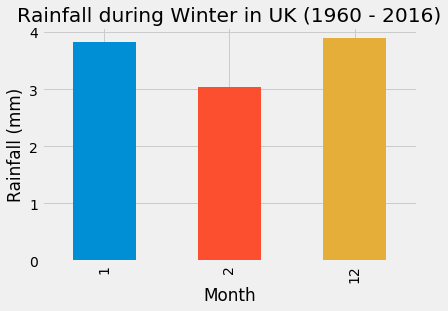

In [39]:
# plotting rainfall for months of winter (Jan=1, Feb=2, Dec=12)

rainfalldf = finaldf.loc[finaldf['Month'].isin(['1','2','12'])]
plt.xlabel('Months')
plt.title('Rainfall during Winter in UK (1960 - 2016)')
plt.ylabel('Rainfall (mm)')
rainfalldf.groupby('Month')['DailyMean'].mean().plot.bar()

In [40]:
# dataframe to hold number of days having rainfall more than 10 mm

daysabovethresholdrainfall = rainfalldf.loc[(rainfalldf['DailyMean'] >= 10)]
print(daysabovethresholdrainfall.dtypes)

YearMonth    datetime64[ns]
DailyMean           float64
Year                  int64
Month                 int64
dtype: object


(array([711858., 715510., 719163., 722815., 726468., 730120., 733773.,
        737425.]), <a list of 8 Text xticklabel objects>)

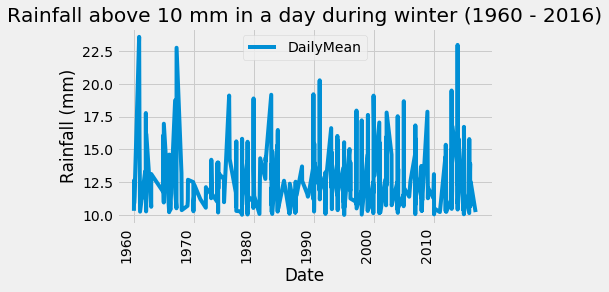

In [41]:
daysabovethresholdrainfall.plot(x = 'YearMonth', y = 'DailyMean')
plt.title('Rainfall above 10 mm in a day during winter (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')

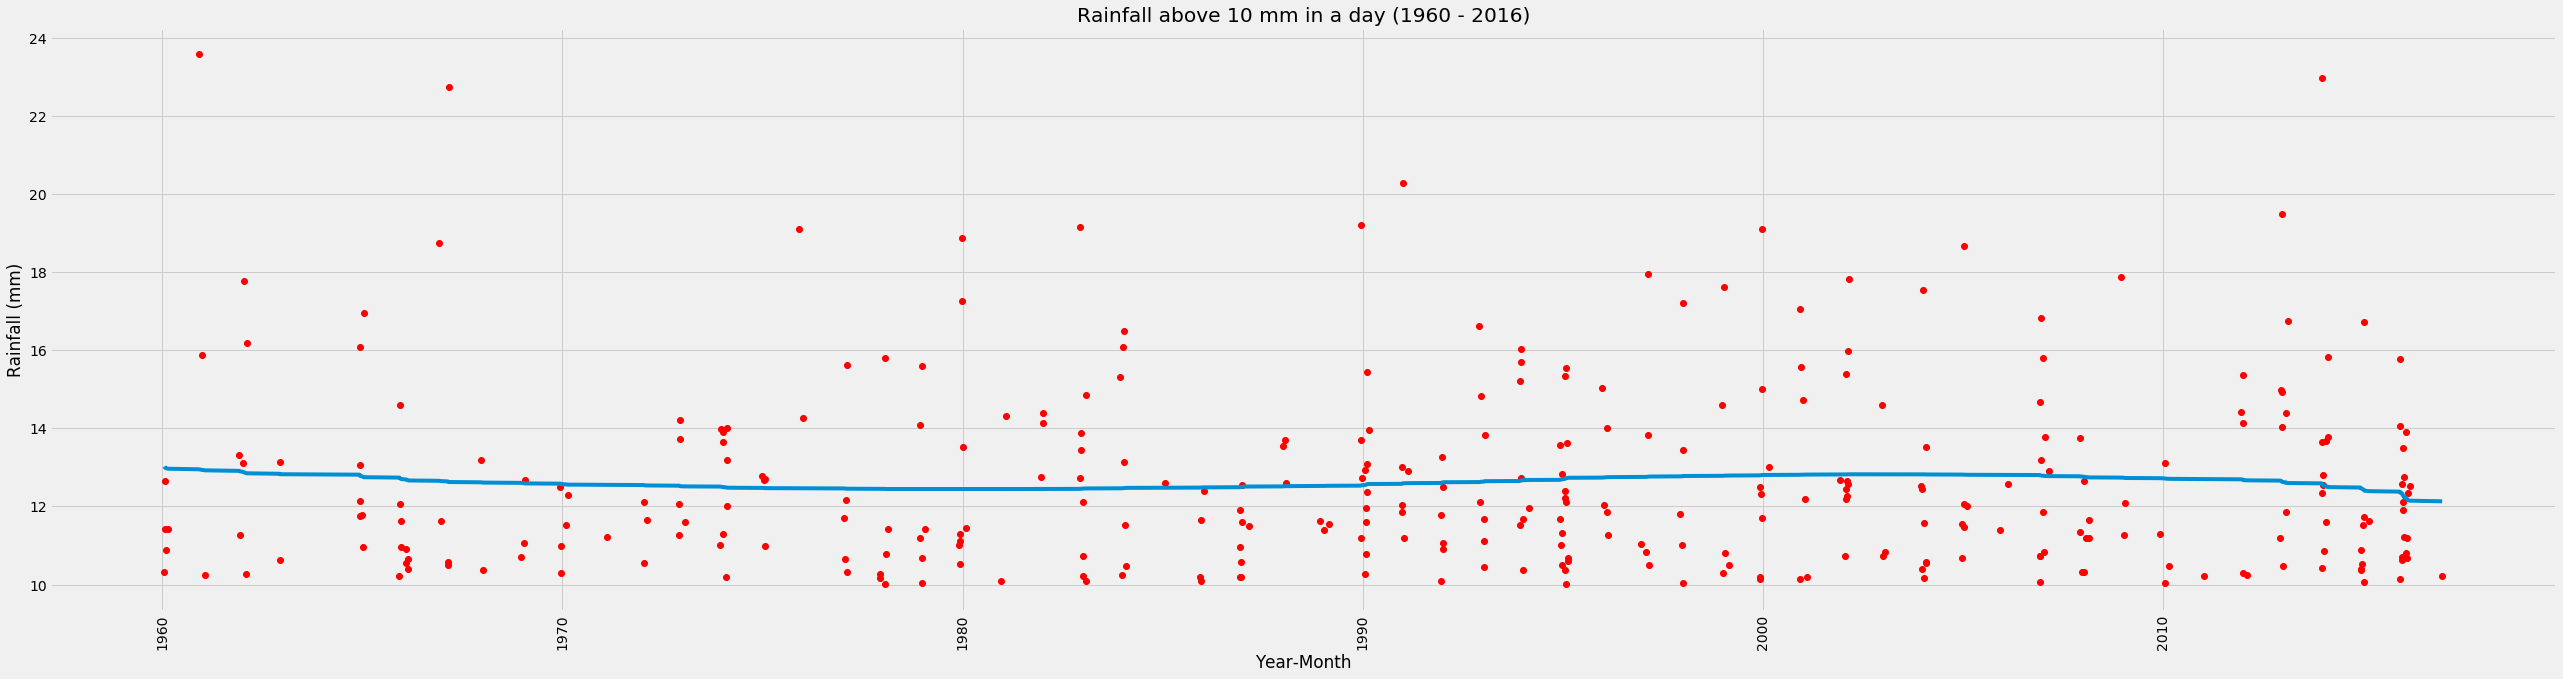

In [42]:
# BEST LINE FIT - the slope of this plot is better (increasing/decreasing) than the previous one
y_values = daysabovethresholdrainfall['DailyMean']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(daysabovethresholdrainfall.loc[:, "DailyMean"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)

fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Rainfall above 10 mm in a day (1960 - 2016)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.plot(daysabovethresholdrainfall.loc[:, "YearMonth"], daysabovethresholdrainfall.loc[:,"DailyMean"], "ro")
plt.plot(daysabovethresholdrainfall.loc[:, "YearMonth"], y_hat)

In [43]:
# dropping redundant columns that are not required for prediction stage
daysabovethresholdrainfall = daysabovethresholdrainfall.drop(['Year', 'Month'], axis=1)

In [44]:
# Count the number of days in a year having rainfall > 10 mm

count = daysabovethresholdrainfall['YearMonth'].groupby([daysabovethresholdrainfall.YearMonth.dt.year]).agg({'count'}).reset_index()

# time series object, frequency, 

In [45]:
test = count
temp = 0

for z in range (10) :
    for i in range(test.shape[0]):
        if (i==0):
            temp = test.iloc[0][0]
        if (test.iloc[i][0] != (temp + i) ):
            test=test.append({'YearMonth': i+temp},{'count': 0.0})
            test = test.sort_values('YearMonth')
            i=0
test = test.replace(float("NaN"),0)

In [46]:
# Create a new dataframe with year and count as two columns
test['YearMonth'] = test['YearMonth'].astype(int)
newdf = pd.DataFrame(test)
newdf.columns = ['Year','Number_of_days']
print(newdf)

    Year  Number_of_days
0   1960             7.0
1   1961             3.0
2   1962             6.0
56  1963             0.0
3   1964             5.0
4   1965             7.0
5   1966             6.0
6   1967             4.0
7   1968             2.0
8   1969             5.0
9   1970             2.0
10  1971             1.0
11  1972             7.0
12  1973             3.0
13  1974             8.0
14  1975             4.0
15  1976             1.0
16  1977             7.0
17  1978             9.0
18  1979             7.0
19  1980             3.0
20  1981             2.0
21  1982             6.0
22  1983             7.0
23  1984             5.0
24  1985             4.0
25  1986             8.0
26  1987             1.0
27  1988             4.0
28  1989             6.0
29  1990            12.0
30  1991             6.0
31  1992             6.0
32  1993             9.0
33  1994             9.0
34  1995            11.0
35  1996             5.0
36  1997             6.0
37  1998             4.0


,Year,Number_of_days
0,1960,7.0
1,1961,3.0
2,1962,6.0
56,1963,0.0
3,1964,5.0
4,1965,7.0
5,1966,6.0
6,1967,4.0
7,1968,2.0
8,1969,5.0


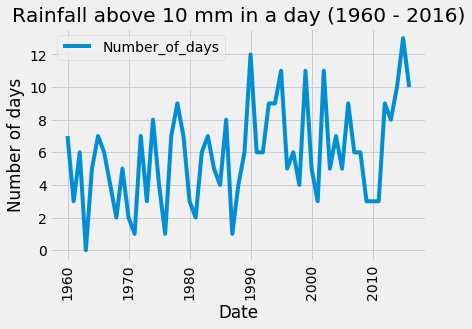

In [64]:
test.plot(x = 'Year', y = 'Number_of_days')
plt.title('Rainfall above 10 mm in a day (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Number of days')
plt.xticks(rotation='vertical')
test
# observations from plot: an upward trend is observed denoting increase in number of days with rainfall > 10 mm

In [65]:
z=pd.DataFrame(test['Year'])
z.insert(1,'Data',test['Number_of_days'])
z.to_csv('WGWP3.csv', index=False)

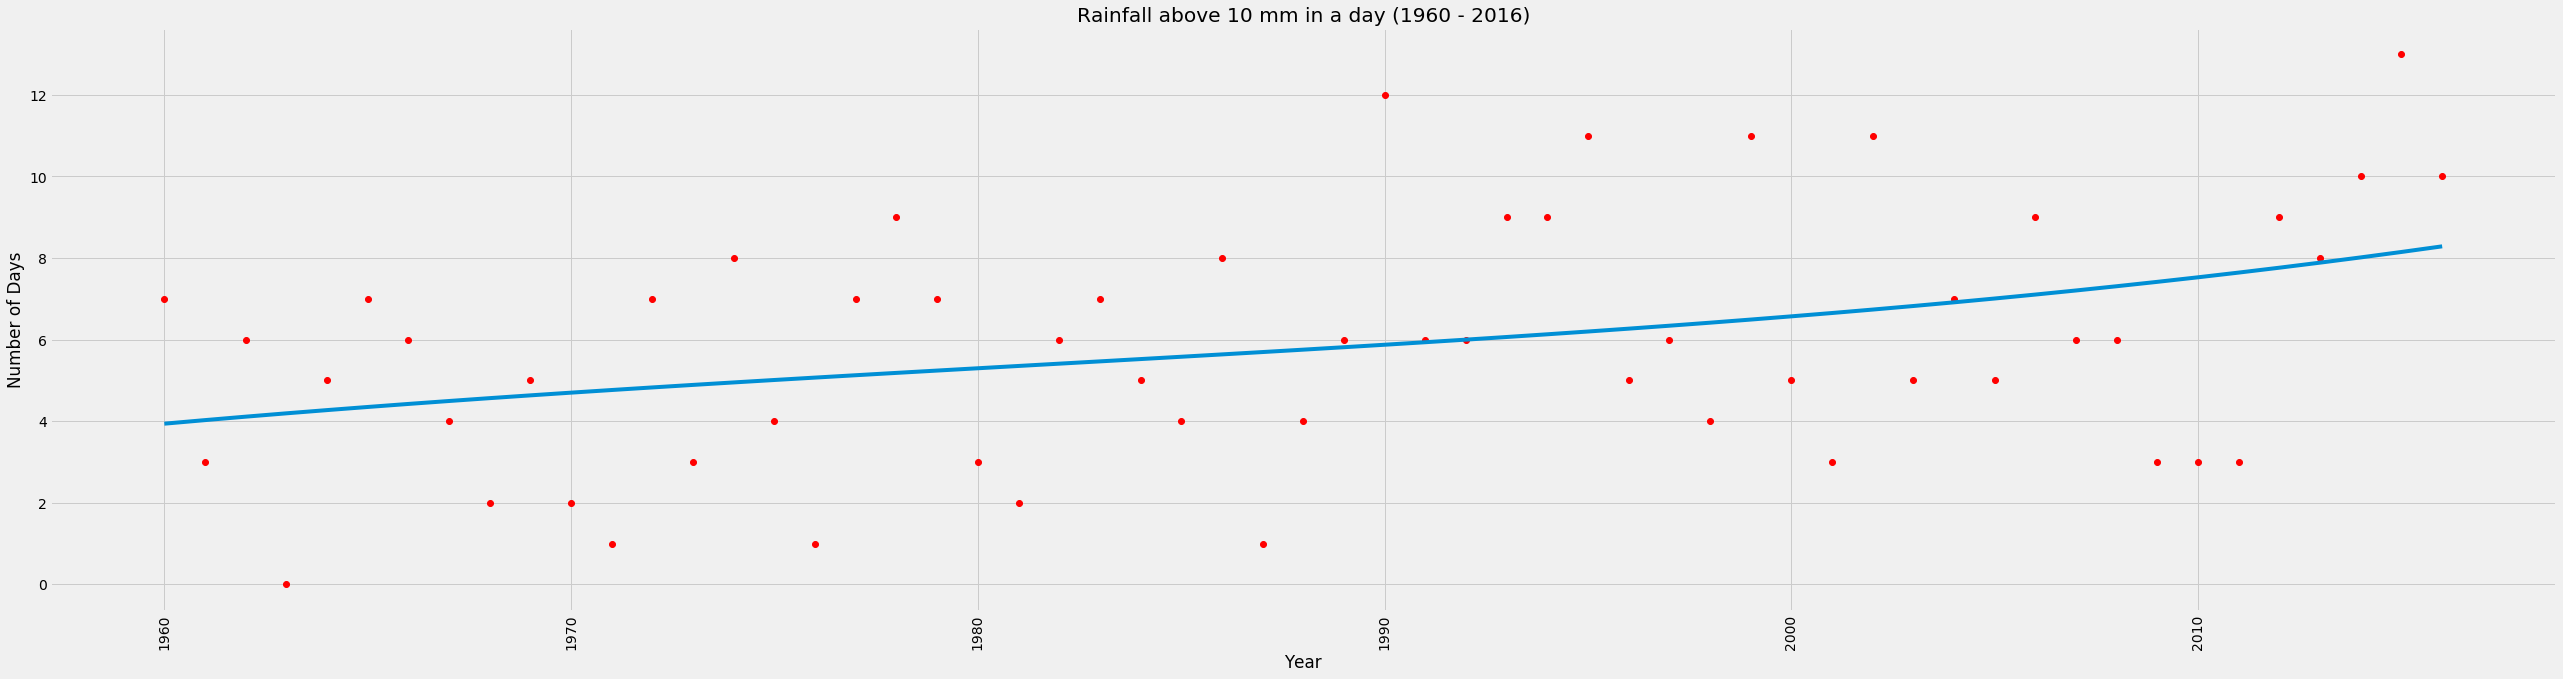

In [48]:
# BEST LINE FIT - to observe the rate of increment in trend of the above plot

y_values = test['Number_of_days']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(test.loc[:, "Number_of_days"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year')
plt.title('Rainfall above 10 mm in a day (1960 - 2016)')
plt.ylabel('Number of Days')
plt.xticks(rotation='vertical')
plt.plot(test.loc[:, "Year"], test.loc[:,"Number_of_days"], "ro")
plt.plot(test.loc[:, "Year"], y_hat)

# observations from plot: best line fit confirms an upward trend in the data during summers

In [66]:
z=pd.DataFrame(y_hat)
z.insert(1,'Year',newdf['Year'])
z.to_csv('WGWP4.csv', index=False)

In [49]:
# ARIMA MODEL - we make use of arima model to predict the future data
# We are not able to pass the "newdf" pandas dataframe directly to arima model
# so we create a csv and then read it as a pandas dataframe - not ideal (HOW DO WE FIX IT?)

In [50]:
test.to_csv('RainfallAbove10.csv', index=False)

In [51]:
df = pd.read_csv('RainfallAbove10.csv', index_col='Year')
df.index = pd.to_datetime(df.index, format='%Y')
print(df.head())
print(df.dtypes)

            Number_of_days
Year                      
1960-01-01             7.0
1961-01-01             3.0
1962-01-01             6.0
1963-01-01             0.0
1964-01-01             5.0
Number_of_days    float64
dtype: object


In [52]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [55]:
# goal here is to use a “grid search” to find the optimal set of parameters(p, d, q) that yields the best performance for our model.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:371.9191844804675
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:277.6868396364202
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:241.60660001921912
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1131.556790123126
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:247.85333965208244
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:238.88823536497142
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:180.45129919224277
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1454.422661976776
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:337.581228561892
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:262.48848062714546
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:239.14290979470778
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1106.047097646499
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:249.83362301251822
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:236.67696664458757
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:182.2046571750924
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1110.469064481037
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:304.01154672167365
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:241.10038130249956
A

In [56]:
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:174.23605857541656
# the above AIC (Akaike Information Critera) value is the lowest of all, so we should consider its corrosponding values as the optimal

# fitting the arima model

mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

"""
coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series
P>|z| column informs us of the significance of each feature weight.
"""

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.272     -0.799      0.424      -0.752       0.316
ma.L1         -0.6564      0.199     -3.294      0.001      -1.047      -0.266
ar.S.L12      -0.5100      0.199     -2.561      0.010      -0.900      -0.120
sigma2        12.3691      4.077      3.034      0.002       4.378      20.360


'\ncoef column shows the weight (i.e. importance) of each feature and how each one impacts the time series\nP>|z| column informs us of the significance of each feature weight.\n'

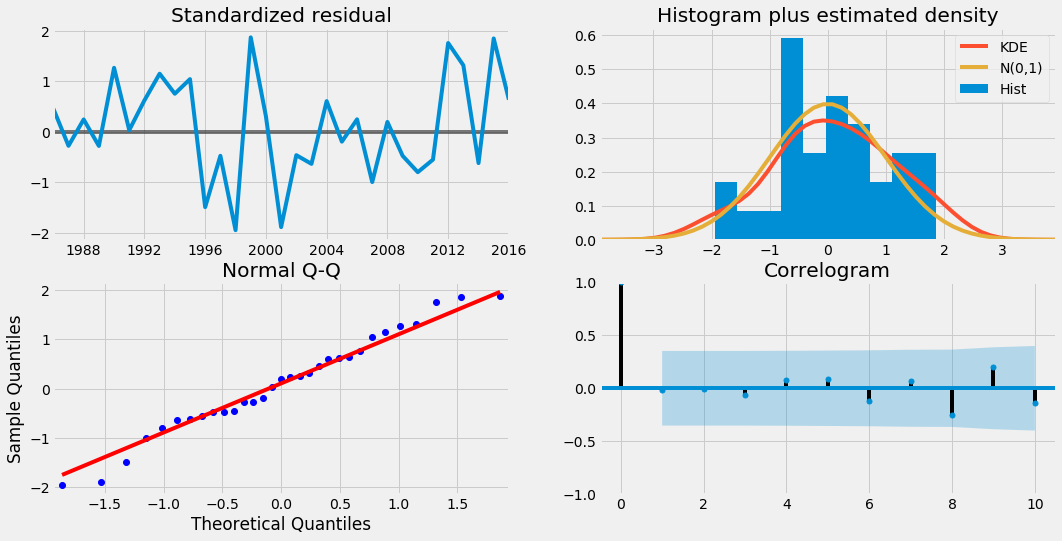

"\nOur model diagnostics suggests that the model residuals are normally distributed based on the following:\n\nIn the top right plot, we see that the red KDE line follows closely with the N(0,1) line \n(where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). \nThis is a good indication that the residuals are normally distributed.\n\nThe qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) \nfollows the linear trend of the samples taken from a standard normal distribution with N(0, 1). \nAgain, this is a strong indication that the residuals are normally distributed.\n\nThe residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. \nThis is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, \nwhich shows that the time series residuals have low correlation with lagged versions of itself.\n"

In [57]:
# model diagnostics to investigate any unusual behavior

results.plot_diagnostics(figsize=(16, 8))
plt.show()

"""
Our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line 
(where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) 
follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). 
Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 
This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, 
which shows that the time series residuals have low correlation with lagged versions of itself.
"""

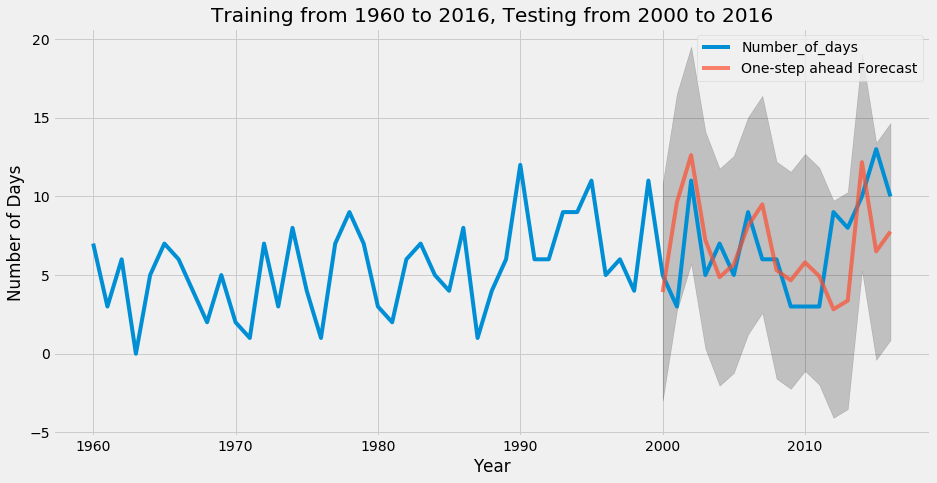

,Number_of_days
Year,
1960-01-01,7.0
1961-01-01,3.0
1962-01-01,6.0
1963-01-01,0.0
1964-01-01,5.0
1965-01-01,7.0
1966-01-01,6.0
1967-01-01,4.0
1968-01-01,2.0


In [70]:
# validating forecasts from 2000-01-01 to the end date 2016-01-01
"""
dynamic=False argument ensures that we produce one-step ahead forecasts, 
meaning that forecasts at each point are generated using the full history up to that point.
"""
pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1960':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1960 to 2016, Testing from 2000 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
df['1960':]
# observations: the predicted plot(orange) is almost similar to the expected plot(blue)

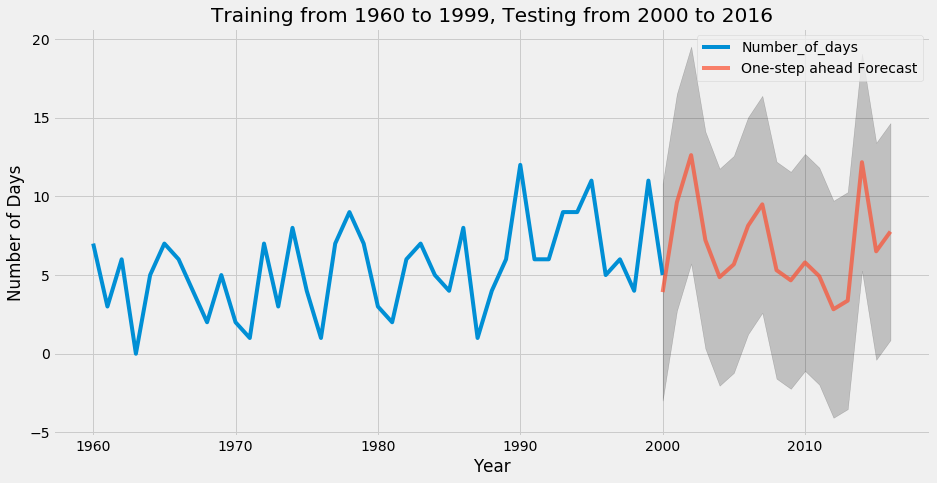

,Number_of_days
Year,
1960-01-01,7.0
1961-01-01,3.0
1962-01-01,6.0
1963-01-01,0.0
1964-01-01,5.0
1965-01-01,7.0
1966-01-01,6.0
1967-01-01,4.0
1968-01-01,2.0


In [72]:
# validating forecasts from 2000-01-01 to the end date 2016-01-01

pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1960':'2000'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1960 to 1999, Testing from 2000 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
df['1960':'2000']

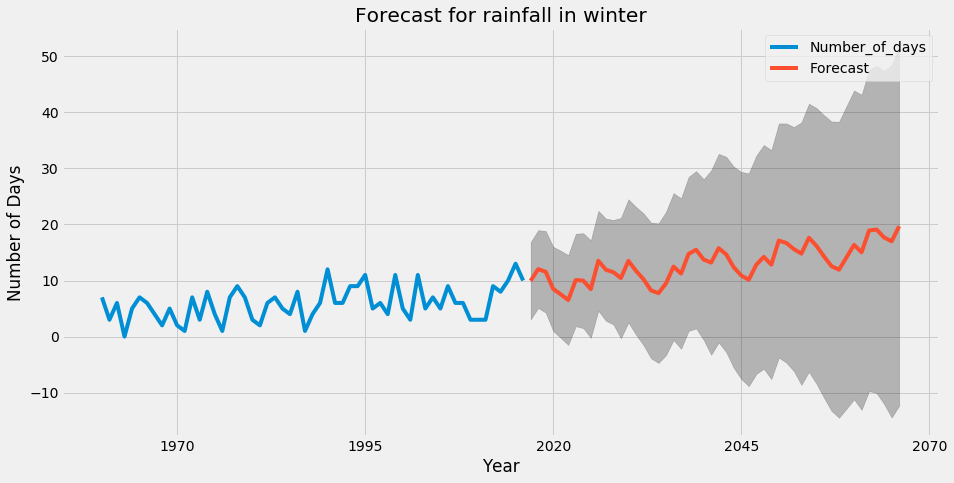

2017-01-01     9.945828
2018-01-01    12.037424
2019-01-01    11.558637
2020-01-01     8.505076
2021-01-01     7.543579
2022-01-01     6.523945
2023-01-01    10.093633
2024-01-01     9.974072
2025-01-01     8.464104
2026-01-01    13.523892
2027-01-01    11.934211
2028-01-01    11.484034
2029-01-01    10.437559
2030-01-01    13.502373
2031-01-01    11.737857
2032-01-01    10.241504
2033-01-01     8.240442
2034-01-01     7.740786
2035-01-01     9.490059
2036-01-01    12.491257
2037-01-01    11.241355
2038-01-01    14.740760
2039-01-01    15.491653
2040-01-01    13.741157
2041-01-01    13.200721
2042-01-01    15.769228
2043-01-01    14.660389
2044-01-01    12.369915
2045-01-01    10.898994
2046-01-01    10.134168
2047-01-01    12.811788
2048-01-01    14.221510
2049-01-01    12.838983
2050-01-01    17.134128
2051-01-01    16.691411
2052-01-01    15.604032
2053-01-01    14.805534
2054-01-01    17.627140
2055-01-01    16.183928
2056-01-01    14.298428
2057-01-01    12.557155
2058-01-01    11

In [71]:
# Get forecast 50 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Forecast for rainfall in winter')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
pred_uc.predicted_mean

In [61]:
y_forecasted = pred.predicted_mean
y_forecasted = y_forecasted.to_frame() 
y_truth = df['2000-01-01':]
y_forecasted.columns = ['Days']
y_forecasted.index.names = ['Year']

# Compute the mean square error
#mse = ((y_forecasted - y_truth) ** 2).mean()
#print('The Mean Squared Error of our forecasts is: {}'.format(round(mse, 2)))

# Compute the root-mean-square
rms = np.sqrt(mean_squared_error(y_forecasted, y_truth))
print('The Root Mean Squared Error of our forecasts is:',rms)

The Root Mean Squared Error of our forecasts is: 3.4020773370658386
